# Video game sales analysis

**Purpose of the research:**
- Identify patterns that determine the success of the game, in order to bet on a potentially popular product and plan advertising campaigns

**Input data from open sources**
- Historical game sales data, user and expert evaluations, genres and platforms 

## 1. Overview of data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy import stats as st
import seaborn as sns

In [26]:
df = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/games.csv')

In [27]:
pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 400)
sns.set(rc={'figure.figsize':(16, 7)})

In [28]:
display(df.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Blanks:** a couple of blanks in the name of the game - they can be removed, because they are useless without the name; Blanks on ratings should try to be filled with markers, the averages here will not be correct to pick up. There are too many of them, it is not necessary to cut the data by them. 

**Data:** the year of the game's release should be brought to the format of the whole, because with the date will be January 1, and the game could be released on any other day of the year. The abbreviation tbd in the rating means that the game has not been rated yet 

## 2. Data preprocessing

I will bring the names of columns to lower case, also some columns (given the human factor, there may be errors), close gaps and replace the type of data

In [30]:
df.columns = map(str.lower, df.columns)
df['name'] = df['name'].str.lower()
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()
df['rating'] = df['rating'].str.lower()
df = df.dropna(subset = ['name'])

I change the gaps and the tbd value in order to make it easier to read the correlation in the future

In [31]:
df['critic_score'] = df['critic_score'].fillna(-77)
df['user_score'] = df['user_score'].fillna(-77)
df['rating'] = df['rating'].fillna(-77)
df['user_score'] = df['user_score'].replace("tbd", -10)

I'm going to give the user ratings to a 100-point scale to make it easier to compare them with the critics' evaluations

In [32]:
df['user_score'] = df['user_score'].astype(float)

def score(number):
    if (number <= 10) and (number >= 0):
        number = number * 10
    return number
 
df['user_score'] = df['user_score'].apply(score)

In [33]:
df['rating'].value_counts()

-77     6764
e       3990
t       2961
m       1563
e10+    1420
ec         8
k-a        3
rp         3
ao         1
Name: rating, dtype: int64

In [34]:
df['rating'] = df['rating'].replace("ec", "e") #early childhood часто имеет рейтинг everyone
df['rating'] = df['rating'].replace("rp", -77) #rating pending
df['rating'] = df['rating'].replace("k-a", "e") #kids to adults или everyone
df['rating'] = df['rating'].replace("ao", "m") #adults only или mature

In [35]:
df = df.dropna(subset = ['year_of_release']) #удалю пропуски для того, чтобы привести данные к нужному виду, их количество незначительное
df['year_of_release'] = df['year_of_release'].astype(int)
df['critic_score'] = df['critic_score'].astype(int)
df['user_score'] = df['user_score'].astype(int)
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,80,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-77,-77,-77
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,83,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,80,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-77,-77,-77


Now I will add a column with total sales for all regions

In [36]:
df['sales_sum'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,80,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-77,-77,-77,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,83,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,80,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-77,-77,-77,31.38


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  int64  
 10  rating           16444 non-null  object 
 11  sales_sum        16444 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.6+ MB


No gaps left

## 3. Data analysis

### 3.1 Let's see how many games were released by year

In [38]:
def decade(row):
    year = row['year_of_release']
    if year <= 1989:
        return '80-e'
    if year <= 1999:
        return '90-e'
    if year <= 2009:
        return '00-e'
    if year <= 2019:
        return '10-e'
    
df['decade'] = df.apply(decade, axis = 1)

In [39]:
df['decade'].value_counts()

00-e    9193
10-e    5277
90-e    1769
80-e     205
Name: decade, dtype: int64

The most games were released between 2000 and 2010. Twice as many games were released in the next decade, but it is limited to 2016, perhaps by the end of the decade with this trend has overtaken. Although, due to increased development costs, this figure may not have increased much. The number of games released in the eighties equaled about 2% of the games released in the noughties

Let's look at a line graph by year.

Text(0, 0.5, 'Sales of games, millions')

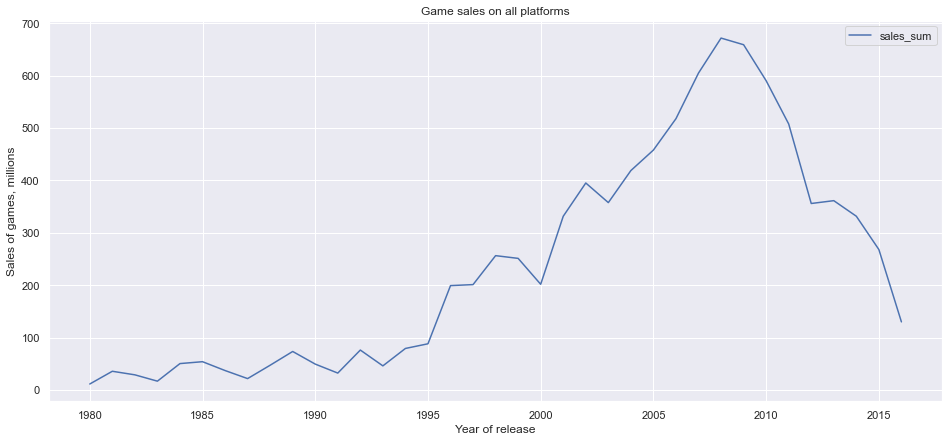

In [40]:
df.pivot_table(index='year_of_release',values='sales_sum',aggfunc='sum').plot(grid=True)
plt.title('Game sales on all platforms')
plt.xlabel('Year of release')
plt.ylabel('Sales of games, millions')

Game sales were roughly flat for 15 years from 1980 to 1995, after which there was a boom that lasted until 2008 and a subsequent decline - which may have been due to the global crisis

### 3.2 Let's look at sales by platform

A quick look at the best-selling consoles in history

In [41]:
df.pivot_table(index = 'platform', values = 'sales_sum', aggfunc = 'sum').sort_values(by = 'sales_sum', ascending = False)

,sales_sum
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


Most of all sold copies of games on PS2, which is logical, because it is the best-selling game console in history. Now let's look at the sales of the top platforms by year, sales are dropping sharply starting with PS4, and we'll cut it off

In [42]:
platform_filtered = ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps'] #creating a list with the top sales platforms
 
df_top = df.query('platform in @platform_filtered and year_of_release >= 1990').pivot_table(index='year_of_release',columns='platform',values='sales_sum',aggfunc='sum')

Text(0, 0.5, 'Sales of games, millions')

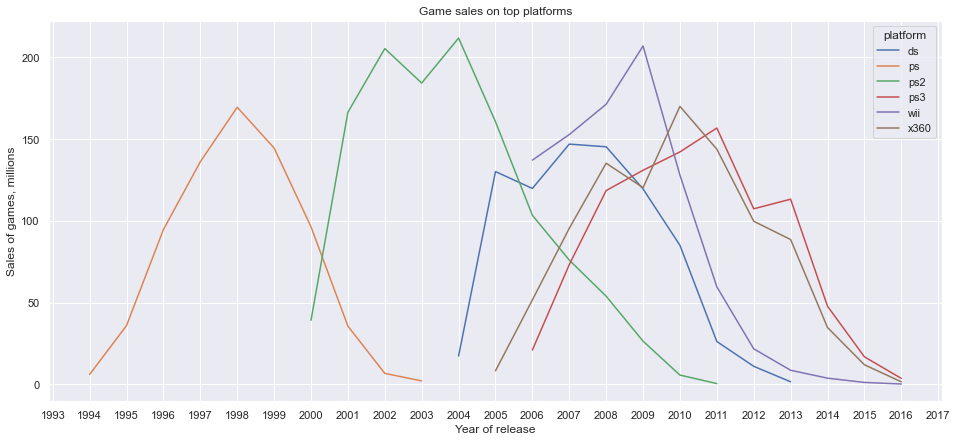

In [43]:
df_top.plot(grid=True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Game sales on top platforms')
plt.xlabel('Year of release')
plt.ylabel('Sales of games, millions')

Judging by the schedule, the life of the platform is about 7-10 years. During this time, the console has time to gain the peak of popularity and retire. I will calculate exactly, let's see what value we get

In [44]:
life_cycle = df.query('platform in ["ps","ps2","ds"] and year_of_release >= 1990').pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['max', 'min'])
display(life_cycle)

,max,min
,year_of_release,year_of_release
platform,,
ds,2013,2004
ps,2003,1994
ps2,2011,2000


The average life expectancy of outdated consoles is 10 years

### 3.3 Let's look at the same data, but for the current time period

For further analysis I will take the data for the period from 2013, as we need to predict for 2017 and beyond, plus in 2013 is the sunset of consoles of the old generation. 

In [45]:
df_new = df.query('year_of_release >= 2013')

In [46]:
df_new.pivot_table(index = 'platform', values = 'sales_sum', aggfunc = 'sum').sort_values(by = 'sales_sum', ascending = False)

,sales_sum
platform,
ps4,314.14
ps3,181.43
xone,159.32
3ds,143.25
x360,136.80
wiiu,64.63
pc,39.43
psv,32.99
wii,13.66


According to the new data, we can see that the new generation consoles (PS4, XBOXone, 3DS and WiiU) are breaking into the leaders, while the sales of the "old" consoles are starting to fall

Next, I'll visually analyze game sales by console using the "mustache box"

Text(0, 0.5, 'Number of games sold, million')

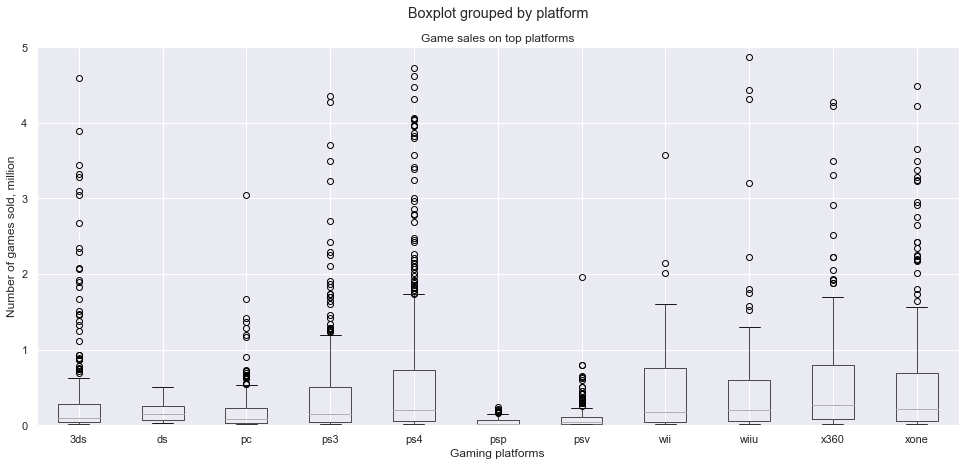

In [47]:
df_new.boxplot('sales_sum', by='platform').set_ylim(0, 5)
plt.title('Game sales on top platforms')
plt.xlabel('Gaming platforms')
plt.ylabel('Number of games sold, million')

The results within whiskers speak of the masses of games selling on consoles. And the outliers talk about blockbusters selling in huge numbers. There are quite a few on the PS4, since it is a console with exclusive content. It is noticeable that the PSP and PSVita are niche consoles, living out their time, as is the DS. Nintendo's Wii and WiiU platforms hardly attract any blockbusters, while their 3DS console has a huge number of them.

### 3.4 I'll look at the correlation between reviews and sales for the most promising console

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


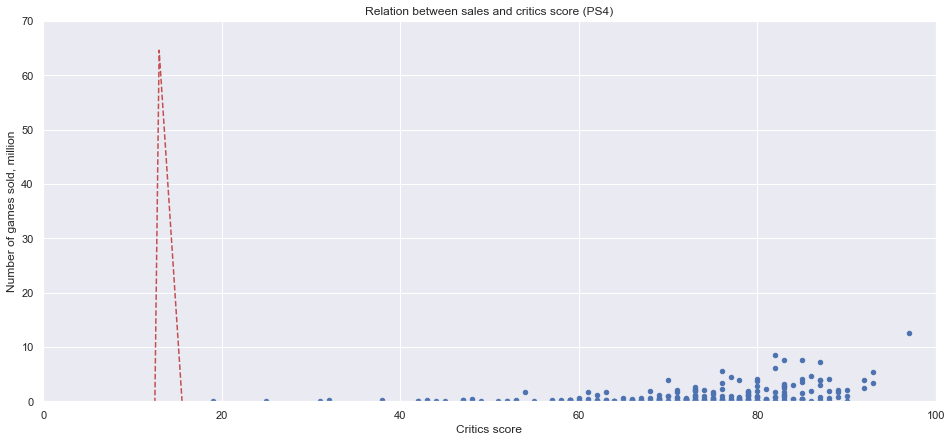

In [48]:
sorted_sum_df = df_new.sort_values('sales_sum')
sorted_sum_df.query('(platform == "ps4") & (critic_score > 0)').plot(x='critic_score', y='sales_sum', kind='scatter', title='Relation between sales and critics score (PS4)', xlim=(0,100), ylim=(0, 70), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['critic_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['critic_score'].sort_values(), p(sorted_sum_df['critic_score'].sort_values()) ,"r--")
plt.xlabel('Critics score')
plt.ylabel('Number of games sold, million')
plt.show()

Most of the games sold limited editions, which makes sense. That said, it is noticeable that the blockbusters with huge sales received the highest score. Starting with a score of 25, game sales began to increase proportionately 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Number of games sold, million')

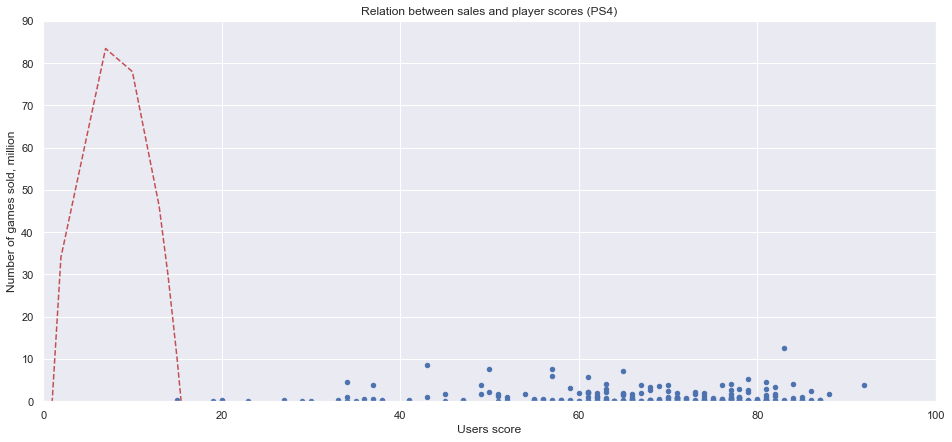

In [49]:
sorted_sum_df.query('(platform == "ps4") & (user_score != -77) & (user_score != -10)').plot(x='user_score', y='sales_sum', kind='scatter', title='Relation between sales and player scores (PS4)', xlim=(0,100), ylim=(0, 90), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['user_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['user_score'].sort_values(), p(sorted_sum_df['user_score'].sort_values()) ,"r--")
plt.xlabel('Users score')
plt.ylabel('Number of games sold, million')

The best games on this console are sold in the average rating (4-5.5), as well as in the highest rating. Some kind of pattern is not clearly observed, apparently games are bought here not because of player ratings

Text(0, 0.5, 'Number of games sold, million')

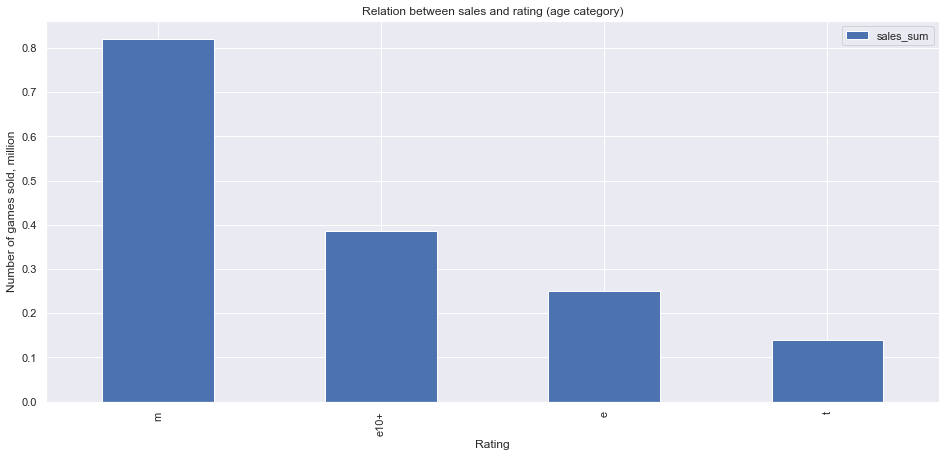

In [50]:
(sorted_sum_df.query('(platform == "ps4") & (rating != -77)').pivot_table(index='rating', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relation between sales and rating (age category)')
plt.xlabel('Rating')
plt.ylabel('Number of games sold, million')

Most games are sold with a rating of Mature (blockbusters often with this rating), then go games for the whole family

In [51]:
df_new['user_score'] = df_new['user_score'].astype(float)
df_top = df_new.query('(critic_score > 0) & (user_score > 0)')

print('Correlation of sales and critical reviews for PS4 games:', 
      (df_top.loc[df_top['platform'] == 'ps4']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ps4']['sales_sum']))
print('Correlation of sales and player reviews for PS4 games:', 
      (df_top.loc[df_top['platform'] == 'ps4']['user_score']).corr(df_top.loc[df_top['platform'] == 'ps4']['sales_sum']))

Correlation of sales and critical reviews for PS4 games: 0.4058948014583661
Correlation of sales and player reviews for PS4 games: -0.03362497596528883


/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Judging from the results, critics' reviews have a greater influence on sales than from players' reviews, which do not have any influence at all. Nevertheless, the coefficient of determination is quite low (less than 50%), which indicates a weak relationship

### 3.5 I'll look at the correlation between reviews and sales for current consoles

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


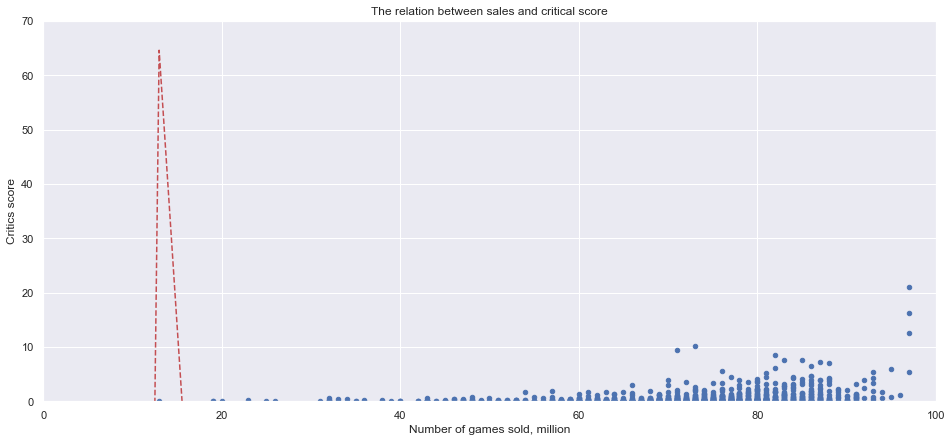

In [52]:
sorted_sum_df = df_new.sort_values('sales_sum')
sorted_sum_df.query('critic_score > 0').plot(x='critic_score', y='sales_sum', kind='scatter', title='The relation between sales and critical score', xlim=(0,100), ylim=(0, 70), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['critic_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['critic_score'].sort_values(), p(sorted_sum_df['critic_score'].sort_values()) ,"r--")
plt.xlabel('Number of games sold, million')
plt.ylabel('Critics score')
plt.show()

Indicators are similar to the leader console, only some blockbusters stand out, apparently the authorship of other platforms

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Number of games sold, million')

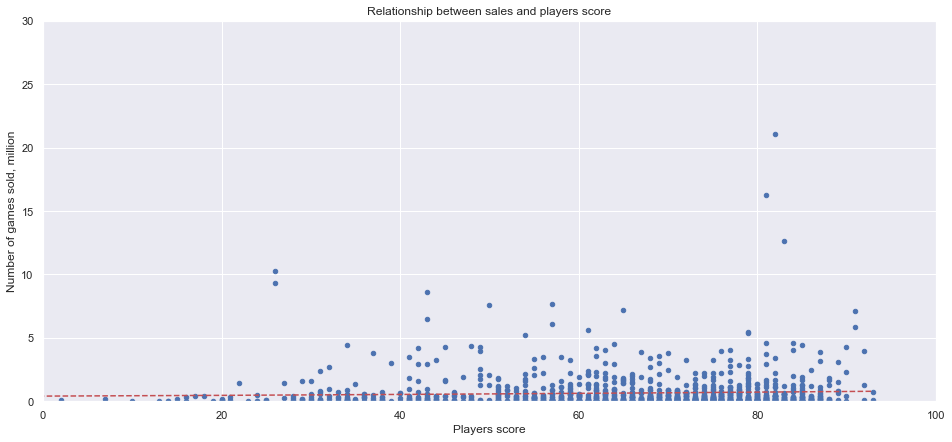

In [53]:
sorted_sum_df.query('(user_score != -77) & (user_score != -10)').plot(x='user_score', y='sales_sum', kind='scatter', title='Relationship between sales and players score', xlim=(0, 100), ylim=(0, 30), grid=True)

z = np.polyfit(sorted_sum_df['user_score'], sorted_sum_df['sales_sum'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['user_score'].sort_values(), p(sorted_sum_df['user_score'].sort_values()) ,"r--")
plt.xlabel('Players score')
plt.ylabel('Number of games sold, million')

There is an anomalous jump at a rating of 2.5. Then the games are sold evenly, and again the jump is around 9. Perhaps it is individual blockbusters that stand out from the rest. In general, it seems that the players' score does not affect the sales of games

Text(0, 0.5, 'Number of games sold, million')

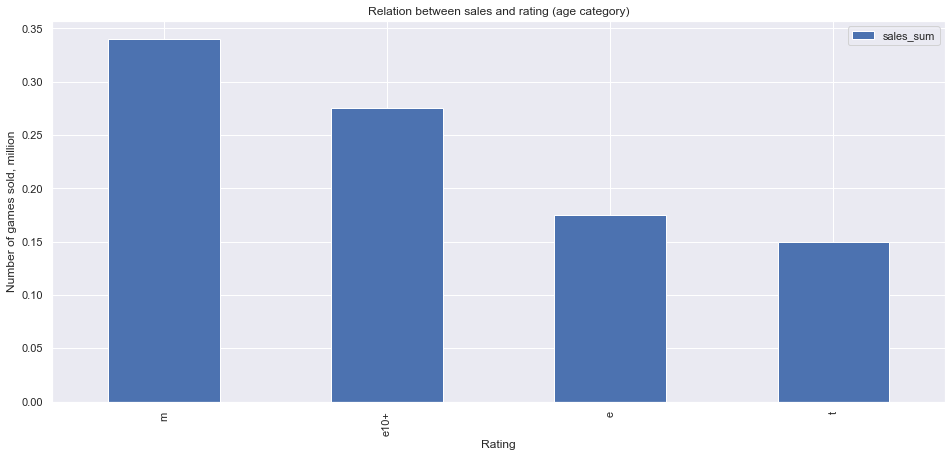

In [54]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relation between sales and rating (age category)')
plt.xlabel('Rating')
plt.ylabel('Number of games sold, million')

Most games are sold with a rating of M, then E10+, then E and T. That is, oddly enough, the best-selling games with a rating of 17+, the so-called blockbusters. Next comes the rating - for all from 10 - these are family games. Marker -77 shows that games with indefinite age restriction is very little


I'll calculate the correlation:

In [55]:
print('Correlation of sales and critical scores for PS3 games:', 
      (df_top.loc[df_top['platform'] == 'ps3']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ps3']['sales_sum']))
print('Correlation of sales and players scores for PS3 games:', 
      (df_top.loc[df_top['platform'] == 'ps3']['user_score']).corr(df_top.loc[df_top['platform'] == 'ps3']['sales_sum']))

print('Correlation of sales and critical scores for XBOXOne games:', 
      (df_top.loc[df_top['platform'] == 'xone']['critic_score']).corr(df_top.loc[df_top['platform'] == 'xone']['sales_sum']))
print('Correlation of sales and players scores for XBOXOne games:', 
      (df_top.loc[df_top['platform'] == 'xone']['user_score']).corr(df_top.loc[df_top['platform'] == 'xone']['sales_sum']))

print('Correlation of sales and critical scores for 3DS games:', 
      (df_top.loc[df_top['platform'] == '3ds']['critic_score']).corr(df_top.loc[df_top['platform'] == '3ds']['sales_sum']))
print('Correlation of sales and players scores for 3DS games:', 
      (df_top.loc[df_top['platform'] == '3ds']['user_score']).corr(df_top.loc[df_top['platform'] == '3ds']['sales_sum']))

print('Correlation of sales and critical scores for XBOX360 games:', 
      (df_top.loc[df_top['platform'] == 'x360']['critic_score']).corr(df_top.loc[df_top['platform'] == 'x360']['sales_sum']))
print('Correlation of sales and players scores for XBOX360 games:', 
      (df_top.loc[df_top['platform'] == 'x360']['user_score']).corr(df_top.loc[df_top['platform'] == 'x360']['sales_sum']))

print('Correlation of sales and critical scores for WiiU games:', 
      (df_top.loc[df_top['platform'] == 'wiiu']['critic_score']).corr(df_top.loc[df_top['platform'] == 'wiiu']['sales_sum']))
print('Correlation of sales and players scores for WiiU games:', 
      (df_top.loc[df_top['platform'] == 'wiiu']['user_score']).corr(df_top.loc[df_top['platform'] == 'wiiu']['sales_sum']))

print('Correlation of sales and critical scores for PC games:', 
      (df_top.loc[df_top['platform'] == 'pc']['critic_score']).corr(df_top.loc[df_top['platform'] == 'pc']['sales_sum']))
print('Correlation of sales and players scores for PC games:', 
      (df_top.loc[df_top['platform'] == 'pc']['user_score']).corr(df_top.loc[df_top['platform'] == 'pc']['sales_sum']))

print('Correlation of sales and critical scores for PSVita games:', 
      (df_top.loc[df_top['platform'] == 'psv']['critic_score']).corr(df_top.loc[df_top['platform'] == 'psv']['sales_sum']))
print('Correlation of sales and players scores for PSVita games:', 
      (df_top.loc[df_top['platform'] == 'psv']['user_score']).corr(df_top.loc[df_top['platform'] == 'psv']['sales_sum']))

print('Correlation of sales and critical scores for Wii games:', 
      (df_top.loc[df_top['platform'] == 'wii']['critic_score']).corr(df_top.loc[df_top['platform'] == 'wii']['sales_sum']))
print('Correlation of sales and players scores for Wii games:', 
      (df_top.loc[df_top['platform'] == 'wii']['user_score']).corr(df_top.loc[df_top['platform'] == 'wii']['sales_sum']))

print('Correlation of sales and critical scores for PSP games:', 
      (df_top.loc[df_top['platform'] == 'psp']['critic_score']).corr(df_top.loc[df_top['platform'] == 'psp']['sales_sum']))
print('Correlation of sales and players scores for PSP games:', 
      (df_top.loc[df_top['platform'] == 'psp']['user_score']).corr(df_top.loc[df_top['platform'] == 'psp']['sales_sum']))

print('Correlation of sales and critical scores for DS games:', 
      (df_top.loc[df_top['platform'] == 'DS']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ds']['sales_sum']))
print('Correlation of sales and players scores for DS games:', 
      (df_top.loc[df_top['platform'] == 'DS']['user_score']).corr(df_top.loc[df_top['platform'] == 'ds']['sales_sum']))


Correlation of sales and critical scores for PS3 games: 0.33380663565061736
Correlation of sales and players scores for PS3 games: 0.02269094327112421
Correlation of sales and critical scores for XBOXOne games: 0.4104220356129637
Correlation of sales and players scores for XBOXOne games: -0.09400318326920858
Correlation of sales and critical scores for 3DS games: 0.33923492878531475
Correlation of sales and players scores for 3DS games: 0.2729904366942444
Correlation of sales and critical scores for XBOX360 games: 0.3503445460228666
Correlation of sales and players scores for XBOX360 games: -0.0062381795323062416
Correlation of sales and critical scores for WiiU games: 0.3795044989978414
Correlation of sales and players scores for WiiU games: 0.4086917438492651
Correlation of sales and critical scores for PC games: 0.19412407903472956
Correlation of sales and players scores for PC games: -0.10923502736171778
Correlation of sales and critical scores for PSVita games: 0.25409970218640765

/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


With the change of generations, critics' reviews have become more influential on game sales - the correlation coefficient between PS4 and PS3 differs by 0.07. At the same time, consoles from Microsoft and Sony have about the same correlation with critics' reviews. 
 
 But player reviews many where (XboxOne, Xbox360, PC) have a correlation either close to zero or slightly negative. This suggests that buyers of games of these consoles do not look at the evaluations of other players, but read the press, before choosing a new game. At 
At the same time PC users are not interested in critics' reviews as well.
 
 Interestingly, the users of some consoles (PSVita, 3DS, WiiU) - look equally at the ratings of both critics and players before buying games.

### 3.6 Sales analysis by genre

Text(0, 0.5, 'Number of games sold, million')

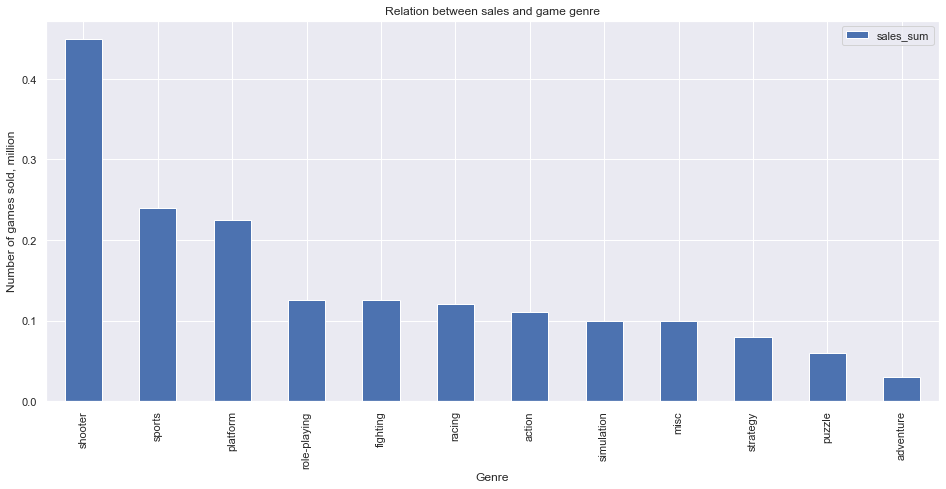

In [56]:
(sorted_sum_df.pivot_table(index='genre', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relation between sales and game genre')
plt.xlabel('Genre')
plt.ylabel('Number of games sold, million')

Best sell shooters (simple shooters), they often belong to the blockbusters, then comes the genre of sports, so popular among not big fans of video games, but with great pleasure playing soccer in the company of friends. Next comes the genre of platformers - games of this genre are often family

## 4. Portrait of users by region

### 4.1 The most popular consoles

In [57]:
df_new.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values(by = 'na_sales', ascending=False)

,na_sales
platform,
ps4,108.74
xone,93.12
x360,81.66
ps3,63.50
3ds,38.20
wiiu,29.21
pc,11.11
wii,6.56
psv,5.04


The most popular platforms in North America are: PS4, XboxOne, Xbox360, PS3  и 3DS  

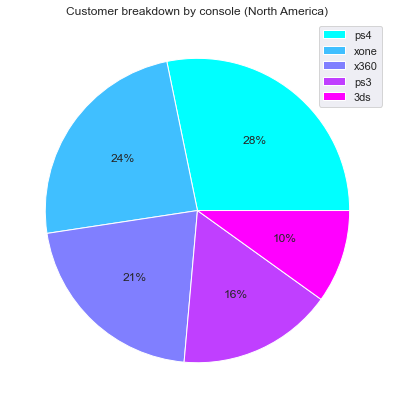

In [58]:
na_filtered = ['ps4', 'xone', 'x360', 'ps3', '3ds'] #creating a list of the region's top platforms
 
na_top = df_new.query('platform in @na_filtered')

(na_top.groupby('platform')['na_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Customer breakdown by console (North America)', cmap='cool'))
plt.show()

In [59]:
df_new.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').sort_values(by = 'jp_sales', ascending=False)

,jp_sales
platform,
3ds,67.81
ps3,23.35
psv,18.59
ps4,15.96
wiiu,10.88
psp,3.29
x360,0.51
xone,0.34
wii,0.05


Japan's most popular platforms are: 3DS, PS3, PSVita, PS4, and WiiU. Still, there they value handheld devices more than home devices.  

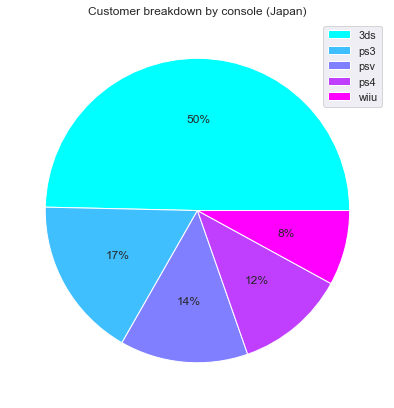

In [60]:
jp_filtered = ['3ds', 'ps3', 'psv', 'ps4', 'wiiu'] #creating a list of the region's top platforms
 
jp_top = df_new.query('platform in @jp_filtered')

(jp_top.groupby('platform')['jp_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Customer breakdown by console (Japan)', cmap='cool'))
plt.show()

In [61]:
df_new.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(by = 'eu_sales', ascending=False)

,eu_sales
platform,
ps4,141.09
ps3,67.81
xone,51.59
x360,42.52
3ds,30.96
pc,25.36
wiiu,19.85
psv,6.10
wii,5.93


Самыми популярными платформами  Европы являются: PS4, PS3, XboxOne, Xbox360  и 3DS  

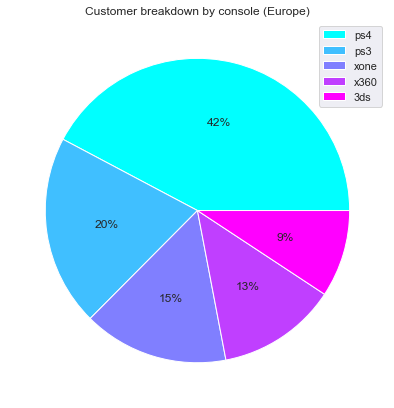

In [62]:
eu_filtered = ['ps4', 'ps3', 'xone', 'x360', '3ds'] #creating a list of the region's top platforms
 
eu_top = df_new.query('platform in @eu_filtered')

(eu_top.groupby('platform')['eu_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Customer breakdown by console (Europe)', cmap='cool'))
plt.show()

### 4.2 The most popular genres

Text(0, 0.5, 'Number of games sold, million')

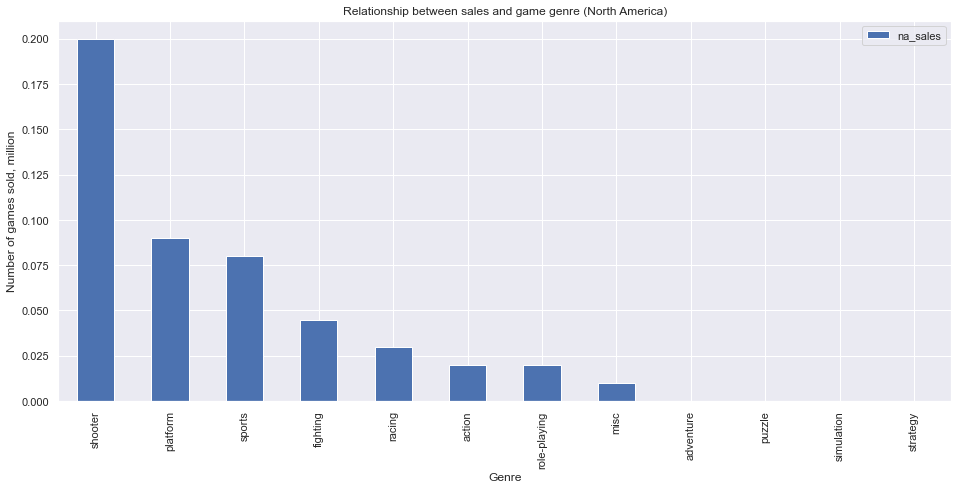

In [63]:
(sorted_sum_df.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values(by='na_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relationship between sales and game genre (North America)')
plt.xlabel('Genre')
plt.ylabel('Number of games sold, million')

In [64]:
na_genre_filtered = ['shooter', 'platform', 'sports', 'fighting', 'racing'] #creating a list of top genres
 
sorted_sum_df.query('genre in @na_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='na_sales',aggfunc='sum')

genre,fighting,platform,racing,shooter,sports
year_of_release,,,,,
2013,3.12,11.35,4.22,30.72,19.14
2014,6.89,3.01,5.92,30.84,19.82
2015,3.70,2.49,2.09,31.94,18.77
2016,1.84,1.29,0.73,16.24,7.54


Text(0, 0.5, 'Number of games sold, million')

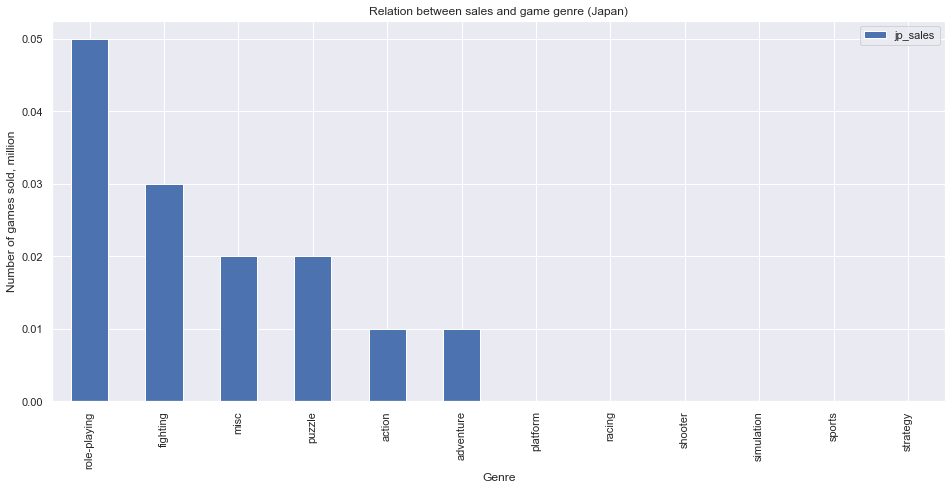

In [65]:
(sorted_sum_df.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values(by='jp_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relation between sales and game genre (Japan)')
plt.xlabel('Genre')
plt.ylabel('Number of games sold, million')

In [66]:
jp_genre_filtered = ['role-playing', 'fighting', 'misc', 'puzzle', 'action'] #creating a list of top genres
 
sorted_sum_df.query('genre in @jp_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='jp_sales',aggfunc='sum')

genre,action,fighting,misc,puzzle,role-playing
year_of_release,,,,,
2013,10.91,1.28,3.59,0.25,19.88
2014,6.53,4.83,2.42,0.41,17.75
2015,15.98,0.79,2.15,0.52,6.80
2016,7.07,0.75,1.04,0.00,6.61


Text(0, 0.5, 'Number of games sold, million')

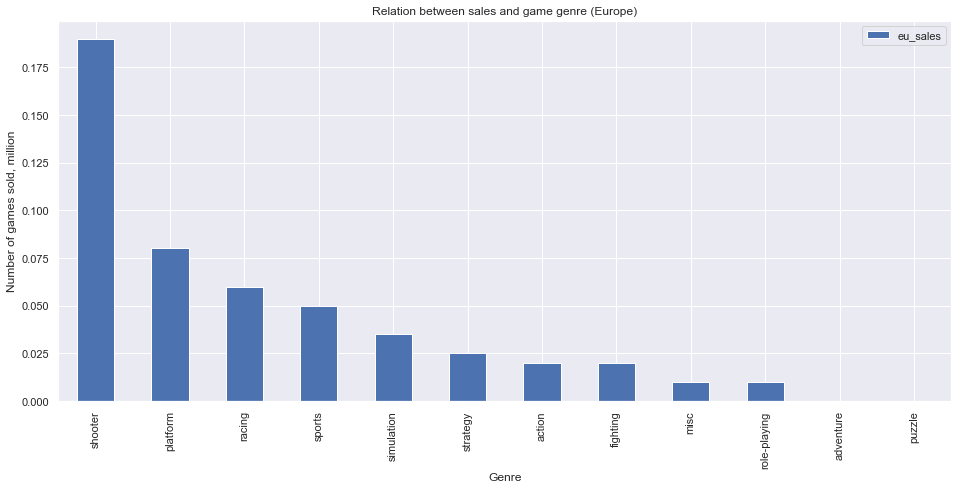

In [67]:
(sorted_sum_df.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values(by='eu_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relation between sales and game genre (Europe)')
plt.xlabel('Genre')
plt.ylabel('Number of games sold, million')

In [68]:
eu_genre_filtered = ['shooter', 'platform', 'racing', 'sports', 'simulation'] #creating a list of top genres
 
sorted_sum_df.query('genre in @eu_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='na_sales',aggfunc='sum')

genre,platform,racing,shooter,simulation,sports
year_of_release,,,,,
2013,11.35,4.22,30.72,2.23,19.14
2014,3.01,5.92,30.84,1.27,19.82
2015,2.49,2.09,31.94,1.20,18.77
2016,1.29,0.73,16.24,0.16,7.54


In Europe and the states, the same genre preference is for shooters and platformers, while in Japan the preference is between racing and shooters and fighting games, which are so popular due to the popularity of arcade games

### 4.3 Impact of age restrictions

Text(0, 0.5, 'Number of games sold, million')

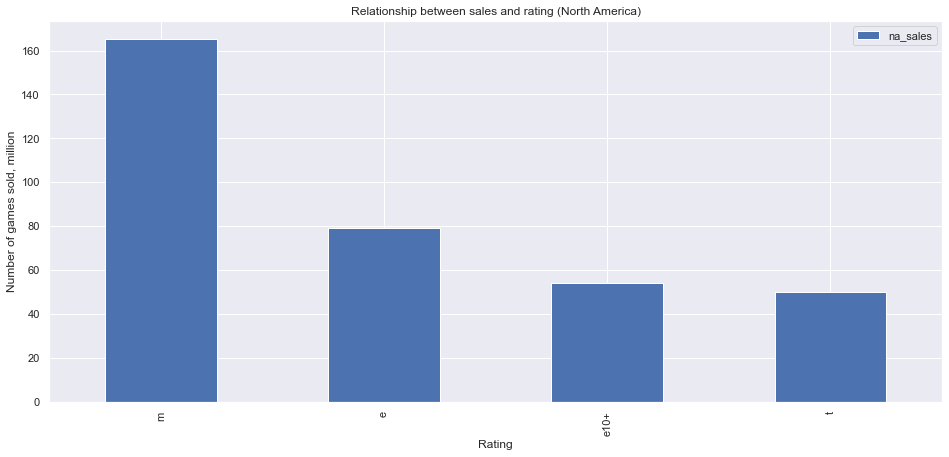

In [69]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relationship between sales and rating (North America)')
plt.xlabel('Rating')
plt.ylabel('Number of games sold, million')

Text(0, 0.5, 'Number of games sold, million')

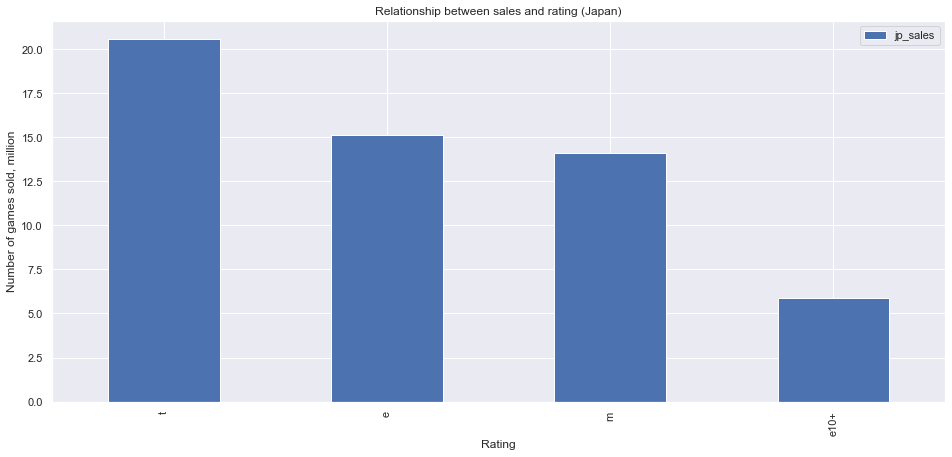

In [70]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relationship between sales and rating (Japan)')
plt.xlabel('Rating')
plt.ylabel('Number of games sold, million')

Text(0, 0.5, 'Number of games sold, million')

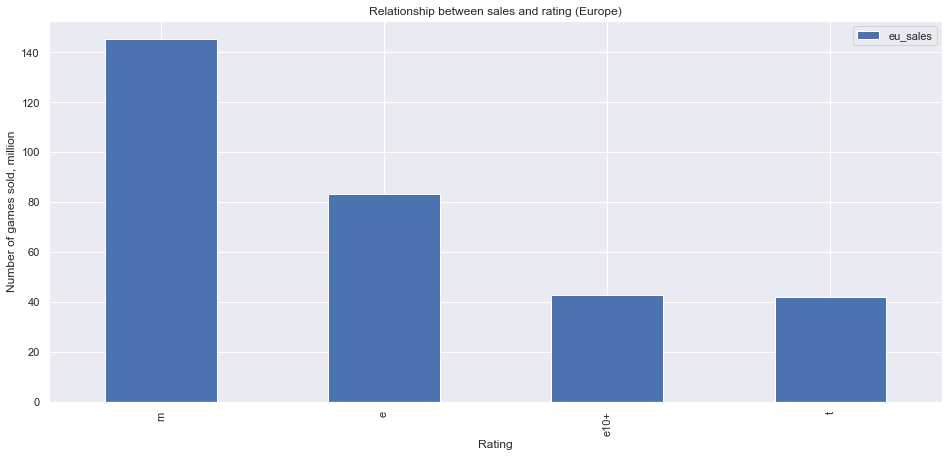

In [71]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Relationship between sales and rating (Europe)')
plt.xlabel('Rating')
plt.ylabel('Number of games sold, million')

In [72]:
sorted_sum_df.query('rating != -77').pivot_table(index='rating', values=['eu_sales', 'jp_sales', 'na_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
e,83.36,15.14,79.05
e10+,42.69,5.89,54.24
m,145.32,14.11,165.21
t,41.95,20.59,49.79


Again, in Europe and the states, games rated for adults and family 10+ are the most played, while in Japan, games for teens 13+ are more appreciated

## 5. Hypothesis testing

First I will test the hypothesis that the average user ratings of XboxOne and PC platforms are the same

H0: Average user ratings for XboxOne equals average user ratings for PC

H1: Average XboxOne user ratings do not equal average PC user ratings

In [73]:
xone_user_rate = df_new.query('platform == "xone" and user_score > 0')['user_score']
pc_user_rate = df_new.query('platform == "pc" and user_score > 0')['user_score']

print('XboxOne average rating: ', xone_user_rate.mean())
print('PC average rating: ', pc_user_rate.mean())

alpha = 0.05 #I take the five percent significance level

results = st.ttest_ind(xone_user_rate, pc_user_rate, equal_var = True) 

print('p-meaning:', results.pvalue) 

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

XboxOne average rating:  65.21428571428571
PC average rating:  62.696774193548386
p-meaning: 0.14012658403611722
It was not possible to reject the null hypothesis


The null hypothesis of equal ratings from XboxOne and PC users is confirmed at the five percent level. 

Or in other words: the average rating values from XboxOne and PC users are equal with 95% probability.

Next, I will test the hypothesis that the average user ratings for the Action and Sports genres are different.

H0: Average user ratings of Action genre is equal to average user ratings of Sports genre

H1: Average user ratings of Action genre is not equal to average user ratings of Sports genre

In [74]:
action_user_rate = df_new.query('genre == "action" and user_score > 0')['user_score']
sports_user_rate = df_new.query('genre == "sports" and user_score > 0')['user_score']

print('Average rating of Action games : ', action_user_rate.mean())
print('Average rating of Sports games : ', sports_user_rate.mean())

alpha = 0.05 #I take the five percent significance level

results = st.ttest_ind(action_user_rate, sports_user_rate, equal_var = True) 

print('p-meaning:', results.pvalue) 

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

Average rating of Action games :  68.37532133676092
Average rating of Sports games :  52.38125
p-meaning: 1.0517832389140778e-27
Rejecting the null hypothesis


The null hypothesis of equal ratings from Action and Sports users is rejected at the 5% level. 

Or in other words: the average ratings from Action and Sports users are not equal with 95% probability.

## 6. Conclusion

**Main conclusions:**
- 1) Observing the history of gaming consoles from the outside, you can pay attention to their life cycles, which last about a decade. Legitimately consoles of the old generation are replaced by new consoles, after all, users are important computing power - graphics and features.
- 2) We can say that the most popular genres in the gaming industry as a whole are shooters and sports, with Japan stands out from the rest, there are also very fighters, it has a portable console in the leaders, probably because in small Japan, each resident has a small amount of square meters of living space, due to this a lot of people at home to play the console is not going.
- 3) Surprisingly, but on large American-European consoles people almost do not follow user ratings when buying new games, they are much more important the opinion of the professional press.